In [1]:
from torch import nn, optim, float32, randn, LongTensor, uint8
import torch
import numpy as np
import torch.nn.functional as F
from dataset.chestxray import ChestXRayDataset
from datahandling.dataloader import get_list_from_txt, extract_annotation_targets, extract_unique_labels
from datahandling.transforms import to_numeric_label, to_class_int
from torch.utils.data import DataLoader
from torchvision import datasets, models
import torchvision.transforms as transforms
import os
import ast
import pandas as pd
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
from dotenv import  load_dotenv
from diffusers import DDPMScheduler, DDPMPipeline
import timeit

/cluster/home/larsira/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Environment Variables

In [2]:
load_dotenv()
debug = ast.literal_eval(os.getenv("DEBUG"))
db_path = os.getenv("DB_PATH")
img_dir_name = os.getenv("IMG_DIR")
class_file_name = os.getenv("CLASSIFICATION_FILE")
train_list = os.getenv("TRAIN_VAL_LIST")
test_list = os.getenv("TEST_LIST")

device="cpu"
if torch.cuda.is_available():
    device="cuda"

print(device, test_list)

cuda test_list.txt


# Set Constants

In [3]:
NUM_TRAIN_TIMESTEPS = 1000
IMG_SIZE = 128
NUM_GENERATE_IMAGES = 9
BATCH_SIZE = 16
WARMUP_STEPS = 100
NUM_EPOCHS=100
LEARNING_RATE= 1e-4
MIXED_PRECISION="fp16"
GRADIENT_ACCUMULATION_STEPS=1
NUM_TIMESTEPS = 100

# Load data

In [4]:
img_dir = os.path.join(db_path, img_dir_name)
annotations_file = os.path.join(db_path, class_file_name)
annotations = pd.read_csv(annotations_file)
annotations = annotations[annotations["Finding Labels"].str.contains("\|") == False].tail(500)
annotations.to_csv(os.path.join(db_path, "small_file.csv"), index=False)
annotations_file = os.path.join(db_path, "small_file.csv")
annotations = pd.read_csv(annotations_file)

preprocess_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5]),
])
train_dataset = ChestXRayDataset(annotations_file, img_dir, transform=preprocess_transforms, read_lib="pil", target_transform=to_class_int)
train_loader = DataLoader(train_dataset, BATCH_SIZE)

# Define Noise Scheduler

In [5]:
# https://huggingface.co/docs/diffusers/tutorials/basic_training#create-a-scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TRAIN_TIMESTEPS)

def schedule_noise(image):
    noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TRAIN_TIMESTEPS)
    noise = randn(image.shape)
    timesteps = LongTensor([50])
    noisy_image = noise_scheduler.add_noise(image, noise, timesteps)
    return noisy_image

# Test Scheduler

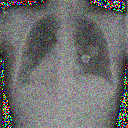

In [6]:
image = next(iter(train_loader))[0]
noised_image = schedule_noise(image)
Image.fromarray(((noised_image.permute(0,2,3,1)+1.0) * 127.5).type(uint8).numpy()[0])

# Define Model

In [7]:
from diffusers import UNet2DModel
model = UNet2DModel(
    sample_size=IMG_SIZE,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256, 512, 512),
    num_class_embeds=len(ChestXRayDataset.target_labels),
    norm_num_groups=32,
    class_embed_type="timestep",
   down_block_types=(
        "DownBlock2D", 
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [8]:
sample_image = train_dataset[0][0].unsqueeze(0)
img, label = train_dataset[0]

print("Input shape:", sample_image.shape)
print("Output shape:", model(sample_image, timestep=0, class_labels=label).sample.shape)

Input shape: torch.Size([1, 3, 128, 128])
Output shape: torch.Size([1, 3, 128, 128])


# Optimizers

In [13]:
def sample_single_image(model, img_size, device, timesteps, epoch):
    with torch.no_grad():
        scheduler = DDPMScheduler(num_train_timesteps=timesteps)
        image = torch.randn(1, 3, img_size, img_size).to(device)
        label = to_class_int("No Finding", ChestXRayDataset.target_labels).to(device)

        for t in scheduler.timesteps:
            output = model(image, timestep=t, class_labels=label, return_dict=False)[0]
            image = scheduler.step(output, t, image).prev_sample

        image = ((image / 2) + .5).clamp(0,1 )
        image = image.permute(0,2,3,1).squeeze().detach().cpu().numpy()
        output = (image * 255).astype(int)
        plt.imshow(output)
        plt.figtext(0.2, 0.01, "Label {} after {} epochs".format("No Finding", epoch), wrap=True)
        plt.savefig('result_{}.png'.format(epoch))
        plt.show()

100%|██████████| 32/32 [00:18<00:00,  1.75it/s]


------------------------------
train loss epoch: 1: 0.0286
Train Learning Rate EPOCH: 1: 3.2000000000000005e-05


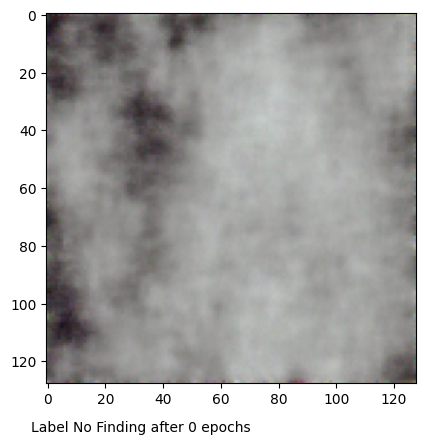

  1%|          | 1/100 [00:54<1:30:08, 54.63s/it]

------------------------------


  2%|▏         | 2/100 [01:12<54:20, 33.27s/it]  

------------------------------
train loss epoch: 2: 0.0229
Train Learning Rate EPOCH: 2: 6.400000000000001e-05
------------------------------


  2%|▏         | 2/100 [01:19<1:04:34, 39.53s/it]

KeyboardInterrupt



In [14]:
from diffusers.optimization import get_cosine_schedule_with_warmup
from accelerate import Accelerator
from tqdm import tqdm

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=(len(train_loader) * NUM_EPOCHS)
)

accelerator = Accelerator(
    mixed_precision=MIXED_PRECISION,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS
)

model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(model, optimizer, train_loader, lr_scheduler)

start = timeit.default_timer()
for epoch in tqdm(range(NUM_EPOCHS), position=0, leave=True):
    model.train()
    train_running_loss=0
    for idx, batch in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        clean_images=batch[0].to(device)
        labels=batch[1].flatten().to(device)
        noise = torch.randn(clean_images.shape).to(device)
        last_batch_size=len(clean_images)

        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (last_batch_size,)).to(device)
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        with accelerator.accumulate(model):
            noise_pred = model(noisy_images, timesteps, return_dict=False, class_labels=labels)[0]
            loss = F.mse_loss(noise_pred, noise)
            accelerator.backward(loss)

            accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            
        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx+1)

    train_learning_rate = lr_scheduler.get_last_lr()[0]
    print("-"*30)
    print(f"train loss epoch: {epoch+1}: {train_loss:.4f}")
    print(f"Train Learning Rate EPOCH: {epoch+1}: {train_learning_rate}")
    if epoch%10 == 0:
        sample_single_image(model, IMG_SIZE, device, 1000, epoch)
        #sample_image_generation(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, NUM_TIMESTEPS)
    print("-"*30)